We assume the images are located in the the `images` folder, itself located at the root folder of the project.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from utils import read_pgm, read_eye_annotations
import numpy as np

In [2]:
image = read_pgm(0)
left_eye, right_eye = read_eye_annotations(img_no=0)

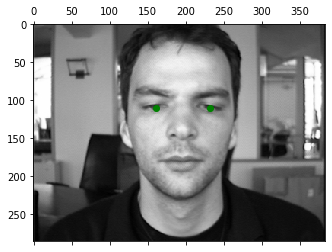

In [3]:
f, ax = plt.subplots()
ax.matshow(image, cmap='gray')
_ = ax.scatter([left_eye[0]], [left_eye[1]], c='green')
_ = ax.scatter([right_eye[0]], [right_eye[1]], c='green')

### Splines

In [4]:
n_t = 10
# on interval 0-1
def make_first_order_spline(i):
    # t0 is 0
    def spline_i(x):
        return 1 * np.logical_and(x >= i, x < i + 1)

    return spline_i

In [5]:
def make_k_th_order_spline(i, k):
    if k == 1:
        return make_first_order_spline(i)

    def spline_k_i(x):
        bk1 = make_k_th_order_spline(i, k - 1)
        bk2 = make_k_th_order_spline(i + 1, k - 1)

        ret1 = (x - i) / (i + k - 1 - i) * bk1(x)
        ret2 = (i + k - x) / (i + k - (i + 1)) * bk2(x)

        return ret1 + ret2

    return spline_k_i

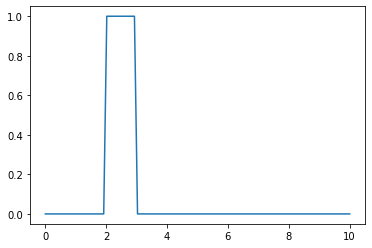

In [6]:
i = 2
Bi1 = make_first_order_spline(i)
xs = np.linspace(0, 10, 100)
ys = Bi1(xs)
plt.plot(xs, ys)

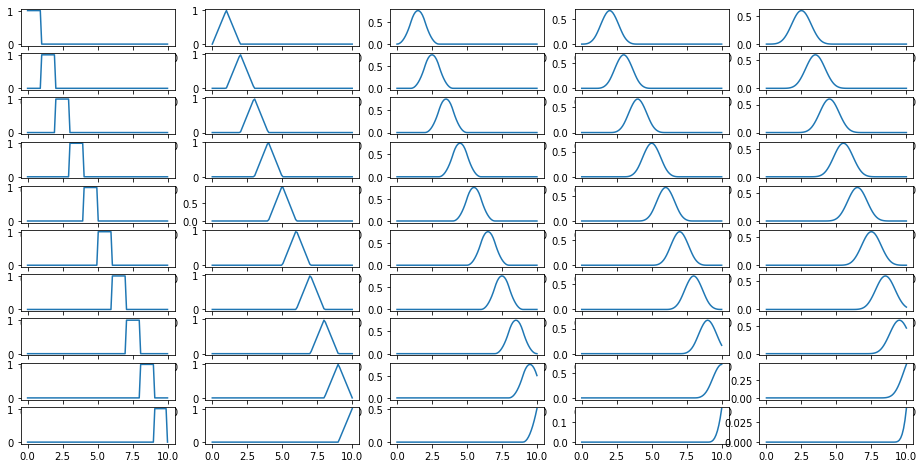

In [7]:
import itertools
plt.subplots(nrows=10, ncols=5, sharex=True, sharey=True, figsize=(16, 8))
j = 0
for i, k in itertools.product(range(10), range(1, 6)):
    Bik = make_k_th_order_spline(i, k)
    xs = np.linspace(0, 10, 100)
    ys = Bik(xs)
    
    j+=1
    plt.subplot(10, 5, j)
    plt.plot(xs, ys)

In [8]:
def make_spline_first_derivative(i, k):
    def b_i_1_derivative(x):
        return 0 * x
    
    if k == 1:
        return b_i_1_derivative
    
    def d_b_ik(x):
        bik1 = make_k_th_order_spline(i, k-1)
        bik2 = make_k_th_order_spline(i+1, k-1)
        
        ret1 = bik1(x) / (i+k - i)
        ret2 = bik2(x) / (i+k+1 - (i+1))
        return k * (ret1 - ret2)
    return d_b_ik

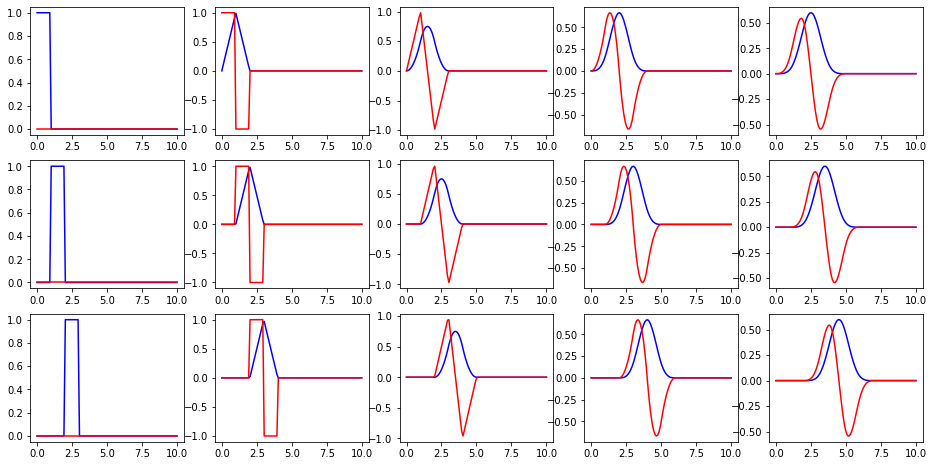

In [9]:
import itertools
plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True ,figsize=(16, 8))
j = 0
for i, k in itertools.product(range(3), range(1, 6)):
    Bik = make_k_th_order_spline(i, k)
    dBik = make_spline_first_derivative(i, k)
    xs = np.linspace(0, 10, 100)
    
    ys = Bik(xs)
    ys_prime = dBik(xs)
    
    j+=1
    plt.subplot(3, 5, j)
    plt.plot(xs, ys, c='b')
    plt.plot(xs, ys_prime, c='r')

In [10]:
def make_2d_spline_patch(n, k, l):
    x = np.linspace(0, 10, 100)
    y = np.linspace(0, 10, 100)
    
    s_x = make_k_th_order_spline(k, n)
    s_y = make_k_th_order_spline(l, n)
    
    spline_x = s_x(x)
    spline_y = s_y(y)
    
    return np.outer(spline_y, spline_x)

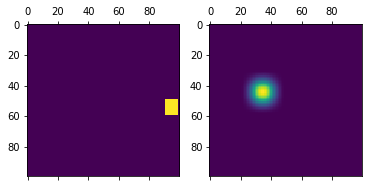

In [11]:
f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)

p = make_2d_spline_patch(1, 9, 5)
_ = ax1.matshow(p)

p = make_2d_spline_patch(3, 2, 3)
_ = ax2.matshow(p)

In [18]:
from scipy.signal import convolve

Nk = 51


def spline_0(x, start=-51, stop=51, granularity=10000):
    """
    Return first order spline
    """
    return np.logical_and(-0.5 <= x, x <= 0.5).astype(int)







def make_spline_n_deg(n, start=-51, stop=51, granularity=1000):
    """
    Return a n-order spline as define in the paper B^n(x) = I_[-0.5, 0.5] (*)^ n I_[-0.5, 0.5]

    Inputs:
    -------
    n (int): The spline's order
    """


    if n == 0:
        return spline_0

    def spline_n(x):

        s = np.linspace(start, stop, granularity)

        # Get the index
        index = np.round(granularity * (x - start) / (stop - start) -1).astype(int)

        # Build previous spline
        spline_prev = make_spline_n_deg(n - 1)

        # Create function
        s_prev = spline_prev(s)

        # Create indicator fonction
        ind = np.logical_and(-0.5 <= s, s <= 0.5).astype(int)

        # Convolve
        conv = np.convolve(ind, s_prev, mode='same') / sum(ind)

        return conv[index]

    return spline_n


def make_2D_spline_deg_n(n, sk=1, sl=1, start=-51, stop=51, granularity=1000):
    """
    Inputs:
    -------
    n (int): Spline degree
    sk (float): scale factor x-axis
    sl (float): scale factor y-axis

    Return the 2D spline B^n_{sk, sl} = B^n(x / sk) * B^n(y / sl)
    """
    Bx = make_spline_n_deg(n, start=start, stop=stop, granularity=granularity)
    By = make_spline_n_deg(n, start=start, stop=stop, granularity=granularity)


    def spline_2D(x, y):

        # Get the index x-axis
        index_x = np.round(granularity * (x - start) / (stop - start) -1).astype(int)

        # Get the index y-axis
        index_y = np.round(granularity * (y - start) / (stop - start) -1).astype(int)

        return np.outer(Bx(x / sk),  By(y / sl))

    return spline_2D


    

    



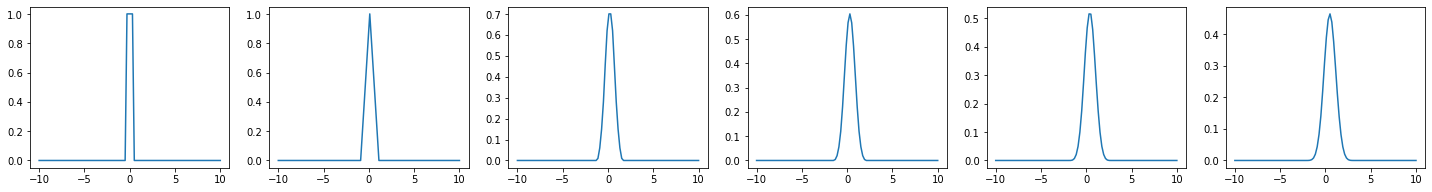

In [39]:
import itertools
plt.subplots(nrows=1, ncols=6, sharex=True, sharey=True, figsize=(25, 35))
j = 0
for k in range(0, 6):
    Bik = make_spline_n_deg(k)
    xs = np.linspace(-10, 10, 100)
    ys = Bik(xs)
    
    j+=1
    plt.subplot(10, 6, j)
    plt.plot(xs, ys)

In [20]:
B2d = make_2D_spline_deg_n(2)

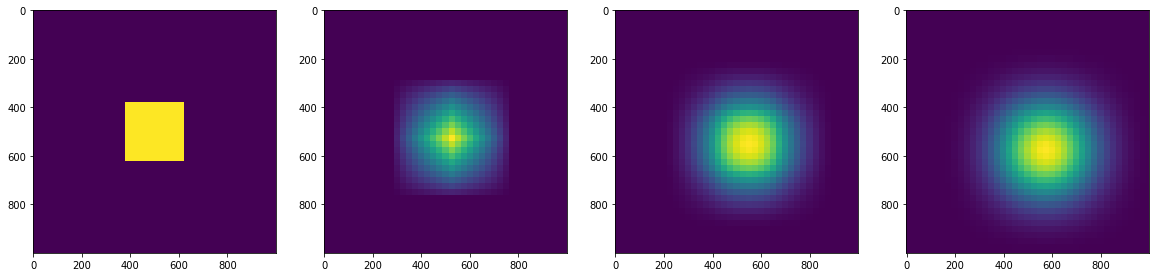

In [24]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 35))

Nx = Ny = 251
Nk = Nl = 51

sk = Nx / Nk
sl = Ny / Nk

x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)

B2d = make_2D_spline_deg_n(0, sk=sk, sl=sl)
ax1.imshow(B2d(x, y))

B2d = make_2D_spline_deg_n(1, sk=sk, sl=sl)
ax2.imshow(B2d(x, y))

B2d = make_2D_spline_deg_n(2, sk=sk, sl=sl)
ax3.imshow(B2d(x, y))

B2d = make_2D_spline_deg_n(3, sk=sk, sl=sl)
ax4.imshow(B2d(x, y))



## Linear regression of patches (no regularization)

In [82]:
Nx = Ny = 251  # Size of training samples
Nk = 51  # Size of the patches (x-direction)
Nl = 51  # Size of the patches (y-direction)
spline_deg = 3  # Degree of the B-spline used